In [13]:
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential, Input, regularizers
from keras.layers.preprocessing.image_preprocessing import Rescaling
import matplotlib.pyplot as plt
import numpy as np
import pydot
import graphviz
import keras_tuner

In [14]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))>0)

Num GPUs Available:  True


In [15]:
batch_size = 32
img_height = 48
img_width = 48


In [16]:

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  'data',
  validation_split=0.3,
  subset="both",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode="grayscale",
  shuffle=True
  )

Found 20019 files belonging to 3 classes.
Using 14014 files for training.
Using 6005 files for validation.


In [17]:
class_names = train_ds.class_names
print(class_names)

['angry', 'happy', 'sad']


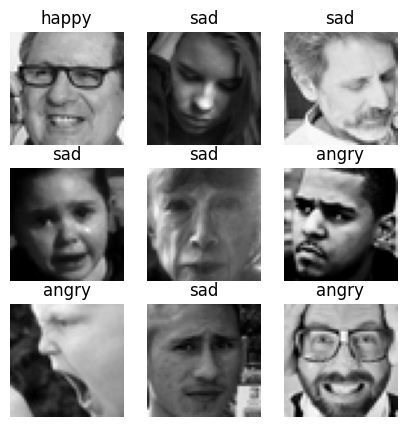

In [18]:
import matplotlib.pyplot as plt
scaler = Rescaling(scale=1.0 / 255)

plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [19]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [51]:
model = Sequential([
    Input(shape=(img_height, img_width, 1)),
    layers.Rescaling(1.0 / 255),
    layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same", kernel_regularizer=regularizers.l2(0.01), ),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same", kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same"),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Flatten(),

    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),

    layers.Dropout(0.3),
    
    layers.Dense(len(class_names), activation="softmax")
])

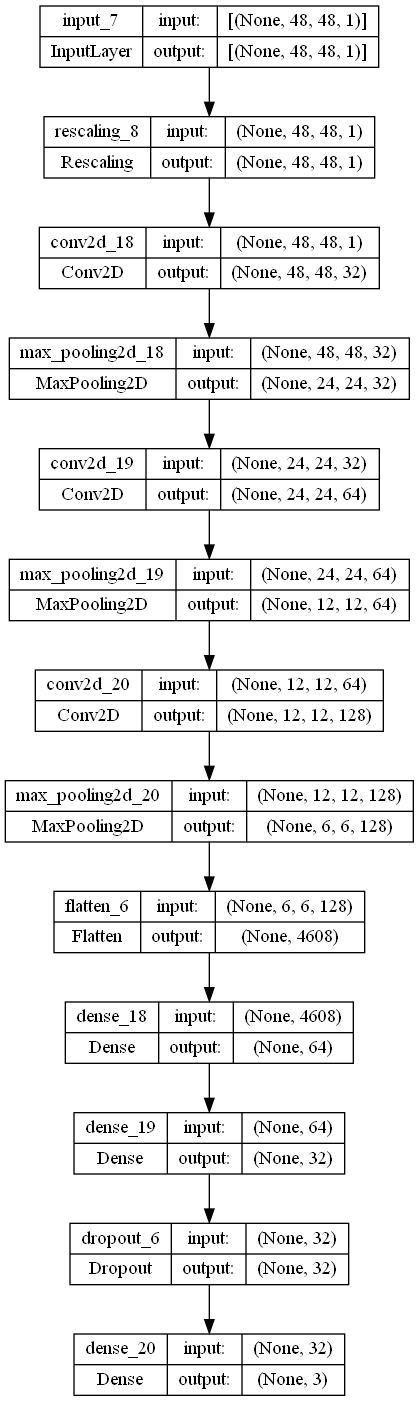

In [52]:
keras.utils.plot_model(model, show_shapes=True)

In [53]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,  restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.5, patience=1, verbose=1)
]


In [54]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(1e-3), metrics=["accuracy"])

In [55]:
history = model.fit(train_ds, batch_size=batch_size, epochs=epochs, callbacks=callbacks, validation_data=val_ds)

Epoch 1/30
438/438 [==============================] - 8s 16ms/step - loss: 1.1006 - accuracy: 0.4530 - val_loss: 1.0386 - val_accuracy: 0.4879 - lr: 0.0010
Epoch 2/30
438/438 [==============================] - 7s 15ms/step - loss: 1.0000 - accuracy: 0.5143 - val_loss: 0.9668 - val_accuracy: 0.5439 - lr: 0.0010
Epoch 3/30
438/438 [==============================] - 7s 15ms/step - loss: 0.9361 - accuracy: 0.5618 - val_loss: 0.9036 - val_accuracy: 0.5774 - lr: 0.0010
Epoch 4/30
438/438 [==============================] - 7s 15ms/step - loss: 0.8899 - accuracy: 0.5867 - val_loss: 0.8812 - val_accuracy: 0.5952 - lr: 0.0010
Epoch 5/30
438/438 [==============================] - 7s 15ms/step - loss: 0.8579 - accuracy: 0.6027 - val_loss: 0.8574 - val_accuracy: 0.6070 - lr: 0.0010
Epoch 6/30
438/438 [==============================] - 7s 15ms/step - loss: 0.8335 - accuracy: 0.6222 - val_loss: 0.8291 - val_accuracy: 0.6240 - lr: 0.0010
Epoch 7/30
438/438 [==============================] - 7s 15ms/st

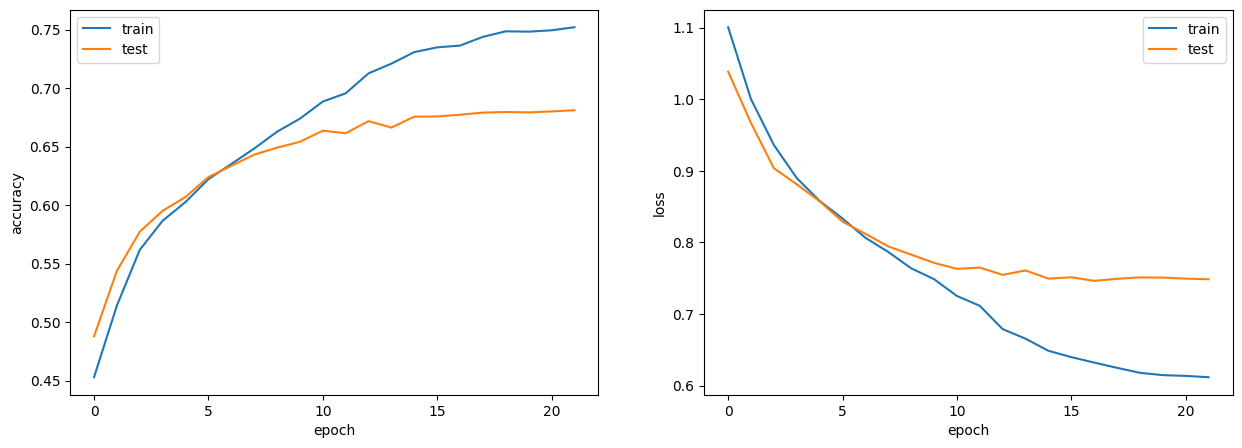

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'])


ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'])

In [57]:
print(max(history.history['accuracy']))
print(max(history.history['val_accuracy']))

0.7520336508750916
0.6810990571975708
